In [77]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mode

import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:

with open('/Users/saniyapatil/Downloads/WESAD/S3/S3.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')

print(data.keys())


dict_keys(['signal', 'label', 'subject'])


In [142]:
signals = data['signal']
labels = data['label']

print(signals.keys())  
print(labels.shape) 


dict_keys(['chest', 'wrist'])
(4545100,)


In [143]:
print(data['signal']['wrist'].keys())
print(data['signal']['chest'].keys())


dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


Accelerometer windows shape: (1297, 320, 3)


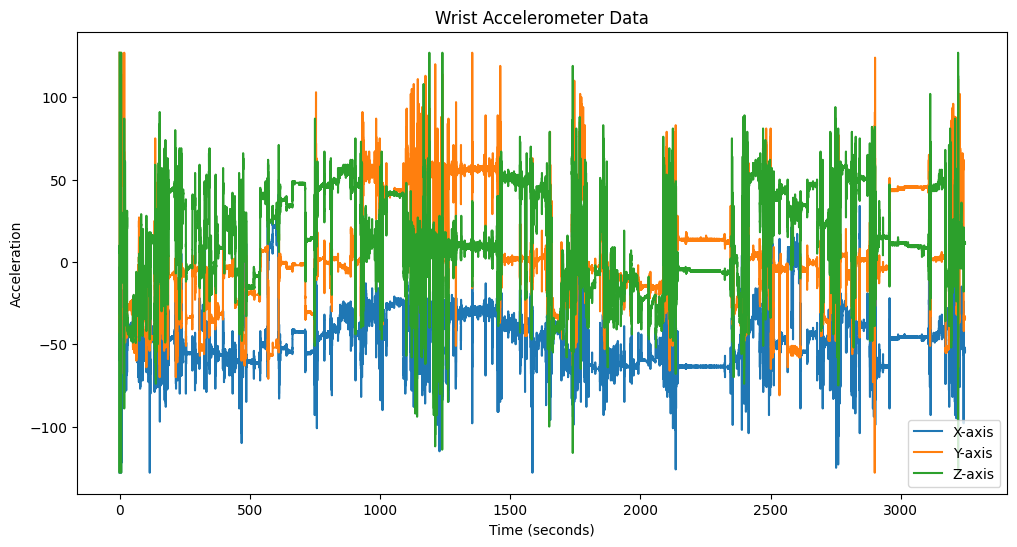

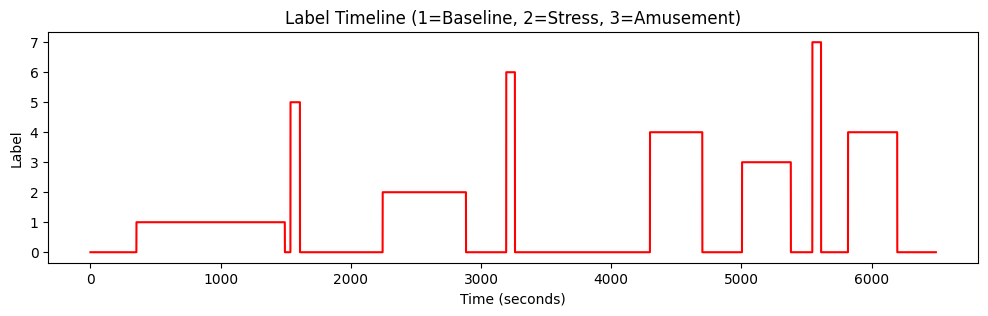

In [ ]:
wrist_data = data['signal']['wrist']
labels = data['label']

acc_data = wrist_data['ACC']    
bvp_data = wrist_data['BVP']   
eda_data = wrist_data['EDA']   
temp_data = wrist_data['TEMP']  

# Sampling rate for wrist sensors (WESAD uses 64 Hz)
sampling_rate = 64  

window_size = 5 * sampling_rate
step_size = 2.5 * sampling_rate

def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, int(step_size)):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)
acc_windows = create_windows(acc_data, window_size, step_size)
print(f"Accelerometer windows shape: {acc_windows.shape}")

time = np.arange(acc_data.shape[0]) / sampling_rate

plt.figure(figsize=(12, 6))
plt.plot(time, acc_data[:, 0], label='X-axis')
plt.plot(time, acc_data[:, 1], label='Y-axis')
plt.plot(time, acc_data[:, 2], label='Z-axis')
plt.title('Wrist Accelerometer Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

time_labels = np.arange(labels.shape[0]) / 700  # assuming chest sampling rate ~700 Hz

plt.figure(figsize=(12, 3))
plt.plot(time_labels, labels, color='red')
plt.title('Label Timeline (1=Baseline, 2=Stress, 3=Amusement)')
plt.xlabel('Time (seconds)')
plt.ylabel('Label')
plt.show()

In [ ]:

downsample_factor = len(labels) // len(acc_data)
labels_downsampled = labels[::downsample_factor]


labels_downsampled = labels_downsampled[:len(acc_data)]

print(f'Downsampled labels length: {len(labels_downsampled)}')


Downsampled labels length: 207776


In [ ]:

sampling_rate = 64  
window_size = 5 * sampling_rate
step_size = 2.5 * sampling_rate

def create_windows(data, labels, window_size, step_size):
    input_windows = []
    window_labels = []

    for start in range(0, len(data) - window_size + 1, int(step_size)):
        end = start + window_size

        window = data[start:end]  
        input_windows.append(window)

        window_label = mode(labels[start:end], keepdims=False)[0]
        window_labels.append(window_label)

    return np.array(input_windows), np.array(window_labels)


In [ ]:

input_windows, window_labels = create_windows(acc_data, labels_downsampled, window_size, step_size)

print(f'Input windows shape: {input_windows.shape}')  
print(f'Window labels shape: {window_labels.shape}')  


Input windows shape: (1297, 320, 3)
Window labels shape: (1297,)


In [ ]:

class WristDataset(Dataset):
    def __init__(self, windows, labels):
        self.windows = torch.tensor(windows, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

dataset = WristDataset(input_windows, window_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)  
        return decoded


In [150]:
model = ConvAutoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(3, 16, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 16, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (3): ReLU()
    (4): ConvTranspose1d(16, 3, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
  )
)


In [ ]:
import torch.optim as optim

num_epochs = 100
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Epoch [1/100], Loss: 795.696896
Epoch [2/100], Loss: 134.032355
Epoch [3/100], Loss: 55.190517
Epoch [4/100], Loss: 36.092653
Epoch [5/100], Loss: 28.672489
Epoch [6/100], Loss: 24.935416
Epoch [7/100], Loss: 20.001341
Epoch [8/100], Loss: 17.417488
Epoch [9/100], Loss: 15.952973
Epoch [10/100], Loss: 14.592225
Epoch [11/100], Loss: 13.492085
Epoch [12/100], Loss: 12.227258
Epoch [13/100], Loss: 12.482230
Epoch [14/100], Loss: 11.165670
Epoch [15/100], Loss: 10.928818
Epoch [16/100], Loss: 10.510877
Epoch [17/100], Loss: 10.360989
Epoch [18/100], Loss: 10.208733
Epoch [19/100], Loss: 9.481191
Epoch [20/100], Loss: 9.554354
Epoch [21/100], Loss: 8.912556
Epoch [22/100], Loss: 9.480544
Epoch [23/100], Loss: 8.851991
Epoch [24/100], Loss: 8.664413
Epoch [25/100], Loss: 8.073938
Epoch [26/100], Loss: 8.190702
Epoch [27/100], Loss: 7.795295
Epoch [28/100], Loss: 8.036922
Epoch [29/100], Loss: 7.384432
Epoch [30/100], Loss: 7.321601
Epoch [31/100], Loss: 7.267846
Epoch [32/100], Loss: 7.8100

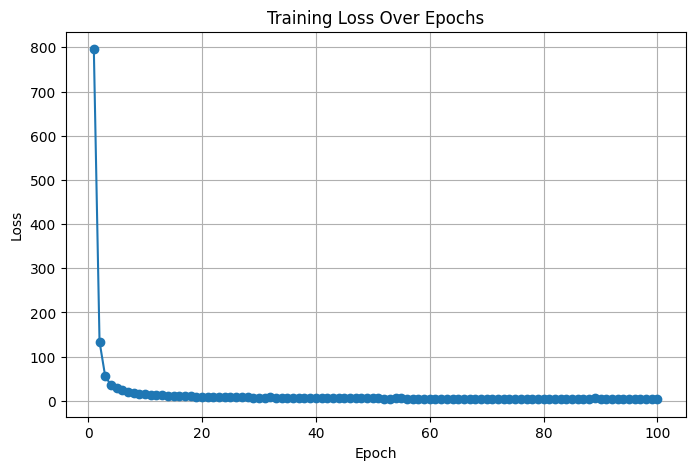

In [153]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


In [ ]:
model.eval()
all_reconstruction_errors = []
all_labels = []

with torch.no_grad():
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        outputs = model(batch_data)

        
        errors = torch.mean((outputs - batch_data) ** 2, dim=[1, 2]).cpu().numpy()
        all_reconstruction_errors.extend(errors)
        all_labels.extend(batch_labels.numpy())

all_reconstruction_errors = np.array(all_reconstruction_errors)
all_labels = np.array(all_labels)

print("Anomaly scores (reconstruction errors) calculated.")


Anomaly scores (reconstruction errors) calculated.


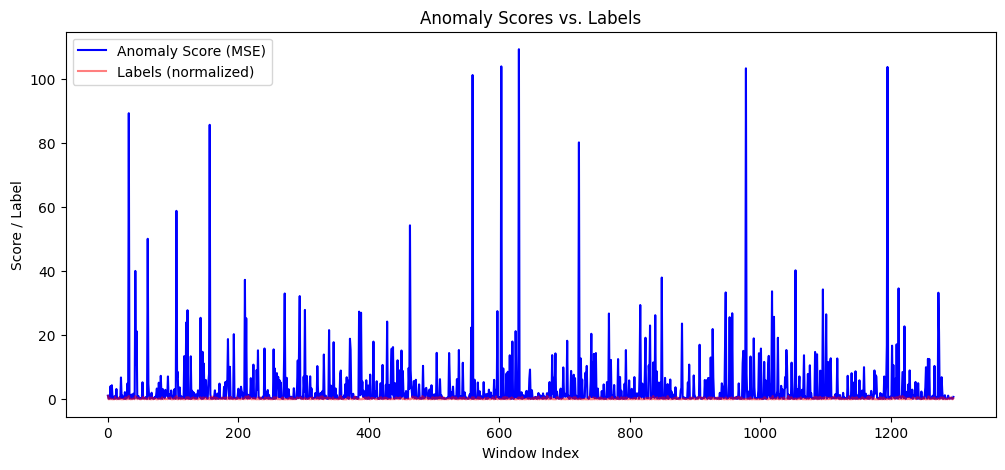

In [155]:
plt.figure(figsize=(12, 5))
plt.plot(all_reconstruction_errors, label='Anomaly Score (MSE)', color='blue')
plt.plot(all_labels / max(all_labels), label='Labels (normalized)', color='red', alpha=0.5)
plt.title('Anomaly Scores vs. Labels')
plt.xlabel('Window Index')
plt.ylabel('Score / Label')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
true_anomalies = (all_labels != 1).astype(int)

thresholds = np.linspace(min(all_reconstruction_errors), max(all_reconstruction_errors), 200)

precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    predicted_anomalies = (all_reconstruction_errors > thresh).astype(int)
    
    precision = precision_score(true_anomalies, predicted_anomalies, zero_division=0)
    recall = recall_score(true_anomalies, predicted_anomalies, zero_division=0)
    f1 = f1_score(true_anomalies, predicted_anomalies, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


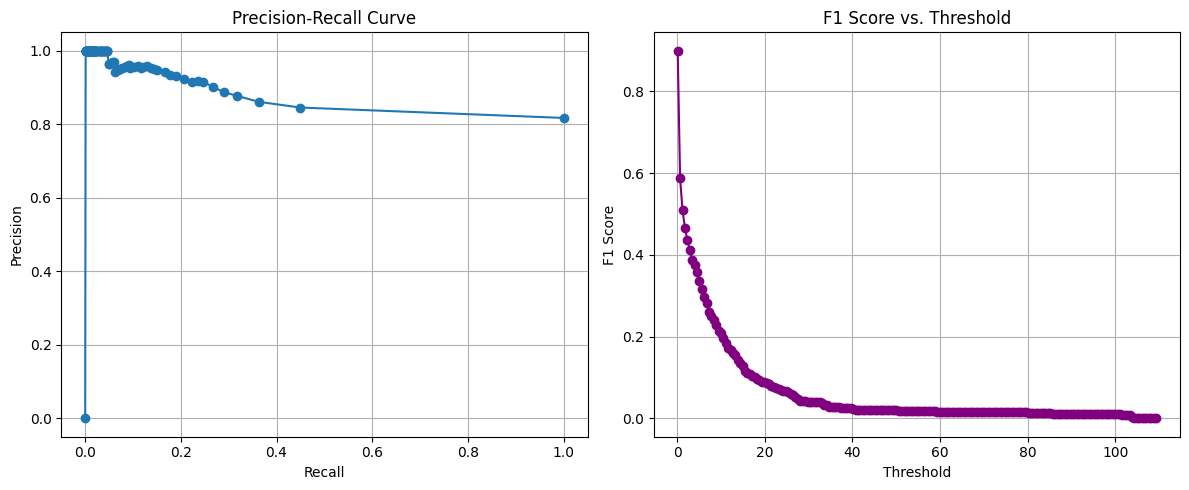

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores, marker='o', color='purple')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid()

plt.tight_layout()
plt.show()


In [158]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f'Best threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {best_f1:.4f}')


Best threshold: 0.1044
Best F1 Score: 0.8994


In [159]:
predicted_anomalies = (all_reconstruction_errors > best_threshold).astype(int)


In [ ]:

# mean_error = np.mean(all_reconstruction_errors)
# std_error = np.std(all_reconstruction_errors)
# threshold = mean_error + 1.0* std_error


# print(f'Anomaly detection threshold: {threshold:.4f}')


In [ ]:

# predicted_anomalies = (all_reconstruction_errors > threshold).astype(int)

# true_anomalies = (all_labels != 1).astype(int)


In [162]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(true_anomalies, predicted_anomalies)
recall = recall_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
cm = confusion_matrix(true_anomalies, predicted_anomalies)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(cm)


Precision: 0.8171
Recall: 1.0000
F1 Score: 0.8994
Confusion Matrix:
[[   1  237]
 [   0 1059]]


In [164]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_anomalies, predicted_anomalies)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8173


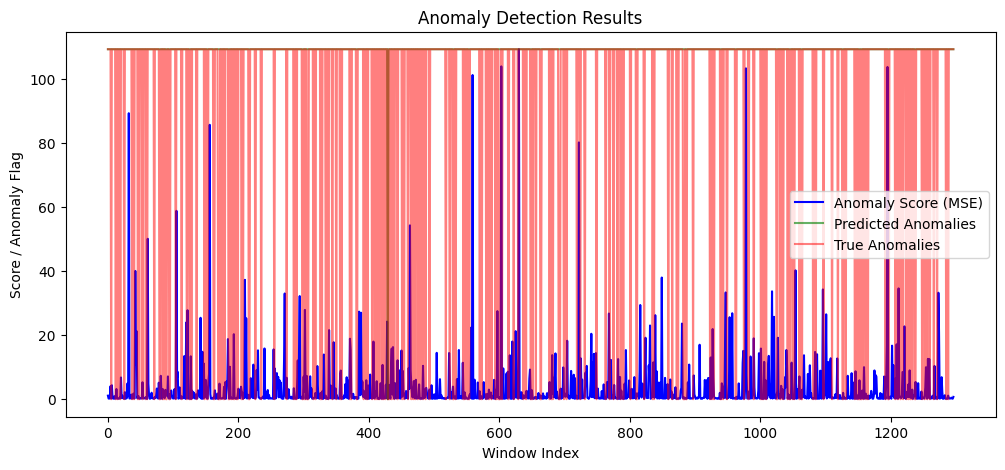

In [163]:
plt.figure(figsize=(12, 5))
plt.plot(all_reconstruction_errors, label='Anomaly Score (MSE)', color='blue')
plt.plot(predicted_anomalies * max(all_reconstruction_errors), label='Predicted Anomalies', color='green', alpha=0.6)
plt.plot(true_anomalies * max(all_reconstruction_errors), label='True Anomalies', color='red', alpha=0.5)
plt.title('Anomaly Detection Results')
plt.xlabel('Window Index')
plt.ylabel('Score / Anomaly Flag')
plt.legend()
plt.show()


Multisensor fusion


In [174]:
from scipy.signal import resample


In [ ]:

target_length = acc_data.shape[0]  

eda_resampled = resample(wrist_data['EDA'], target_length)
temp_resampled = resample(wrist_data['TEMP'], target_length)

if wrist_data['BVP'].shape[0] > target_length:
    bvp_resampled = wrist_data['BVP'][:target_length]  
else:
    bvp_resampled = resample(wrist_data['BVP'], target_length)

acc_data = acc_data[:target_length]
bvp_resampled = bvp_resampled[:target_length]
eda_resampled = eda_resampled[:target_length]
temp_resampled = temp_resampled[:target_length]

labels = labels[:target_length]

print(f"Aligned Signal Length: {target_length}")


Aligned Signal Length: 207776


In [ ]:
def create_multi_windows(acc, bvp, eda, temp, labels, window_size, step_size):
    input_windows = []
    window_labels = []

    for start in range(0, len(acc) - window_size + 1, int(step_size)):
        end = start + window_size

        acc_window = acc[start:end]               
        bvp_window = bvp[start:end].reshape(-1, 1)   
        eda_window = eda[start:end].reshape(-1, 1)   
        temp_window = temp[start:end].reshape(-1, 1) 
        combined_window = np.hstack((acc_window, bvp_window, eda_window, temp_window))
        input_windows.append(combined_window)

        window_label = mode(labels[start:end], keepdims=False)[0]
        window_labels.append(window_label)

    return np.array(input_windows), np.array(window_labels)

input_windows, window_labels = create_multi_windows(
    acc_data, bvp_resampled, eda_resampled, temp_resampled, labels, window_size, step_size
)

print(f"Input windows shape: {input_windows.shape}")


Input windows shape: (1297, 320, 6)


In [177]:
dataset = WristDataset(input_windows, window_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=6, d_model=64, nhead=4, num_layers=3, dropout=0.1):
        super(TransformerAutoencoder, self).__init__()

        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_projection = nn.Linear(d_model, input_dim)

    def forward(self, x):
       
        x = self.input_projection(x)  
        x = x.permute(1, 0, 2)  

        encoded = self.transformer_encoder(x)  
        encoded = encoded.permute(1, 0, 2)  

        output = self.output_projection(encoded)  
        return output


In [179]:
model = TransformerAutoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)


TransformerAutoencoder(
  (input_projection): Linear(in_features=6, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_projection): Linear(in_features=64, out_features=6, bias=True)
)


In [ ]:
import torch.optim as optim

num_epochs = 100 
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [181]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Epoch [1/100], Loss: 947.047167
Epoch [2/100], Loss: 913.702078
Epoch [3/100], Loss: 903.251128
Epoch [4/100], Loss: 895.841511
Epoch [5/100], Loss: 886.419763
Epoch [6/100], Loss: 878.390518
Epoch [7/100], Loss: 869.158907
Epoch [8/100], Loss: 860.978408
Epoch [9/100], Loss: 850.646426
Epoch [10/100], Loss: 841.351692
Epoch [11/100], Loss: 832.229979
Epoch [12/100], Loss: 822.648080
Epoch [13/100], Loss: 816.486685
Epoch [14/100], Loss: 802.666307
Epoch [15/100], Loss: 792.499266
Epoch [16/100], Loss: 781.388356
Epoch [17/100], Loss: 770.492668
Epoch [18/100], Loss: 760.224544
Epoch [19/100], Loss: 750.229799
Epoch [20/100], Loss: 740.760773
Epoch [21/100], Loss: 729.492482
Epoch [22/100], Loss: 719.494148
Epoch [23/100], Loss: 708.396206
Epoch [24/100], Loss: 698.318955
Epoch [25/100], Loss: 687.720821
Epoch [26/100], Loss: 677.111989
Epoch [27/100], Loss: 667.388466
Epoch [28/100], Loss: 657.364070
Epoch [29/100], Loss: 646.786009
Epoch [30/100], Loss: 636.079718
Epoch [31/100], Los

In [182]:
model.eval()
all_reconstruction_errors = []
all_labels = []

with torch.no_grad():
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        outputs = model(batch_data)

        errors = torch.mean((outputs - batch_data) ** 2, dim=[1, 2]).cpu().numpy()
        all_reconstruction_errors.extend(errors)
        all_labels.extend(batch_labels.numpy())

all_reconstruction_errors = np.array(all_reconstruction_errors)
all_labels = np.array(all_labels)


In [183]:
# Baseline = 1 → Normal
# Stress = 2 or Amusement = 3 → Anomalies
true_anomalies = (all_labels != 1).astype(int)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(min(all_reconstruction_errors), max(all_reconstruction_errors), 200)

precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    predicted_anomalies = (all_reconstruction_errors > thresh).astype(int)

    precision = precision_score(true_anomalies, predicted_anomalies, zero_division=0)
    recall = recall_score(true_anomalies, predicted_anomalies, zero_division=0)
    f1 = f1_score(true_anomalies, predicted_anomalies, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


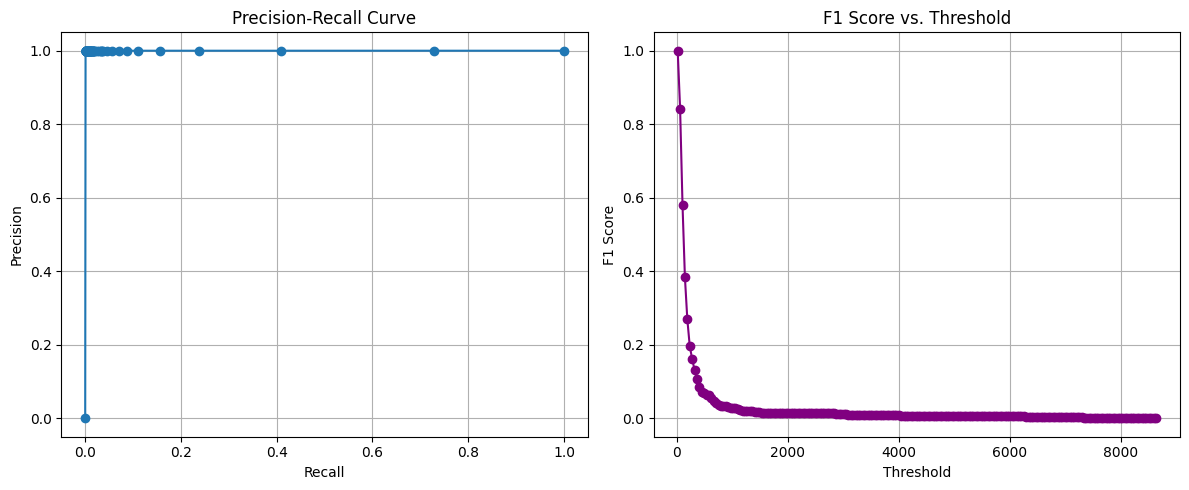

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores, marker='o', color='purple')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {best_f1:.4f}')

final_predicted_anomalies = (all_reconstruction_errors > best_threshold).astype(int)

from sklearn.metrics import confusion_matrix

final_precision = precision_score(true_anomalies, final_predicted_anomalies)
final_recall = recall_score(true_anomalies, final_predicted_anomalies)
final_f1 = f1_score(true_anomalies, final_predicted_anomalies)
final_cm = confusion_matrix(true_anomalies, final_predicted_anomalies)

print(f'Final Precision: {final_precision:.4f}')
print(f'Final Recall: {final_recall:.4f}')
print(f'Final F1 Score: {final_f1:.4f}')
print('Final Confusion Matrix:')
print(final_cm)


Best Threshold: 19.0192
Best F1 Score: 0.9996
Final Precision: 1.0000
Final Recall: 0.9992
Final F1 Score: 0.9996
Final Confusion Matrix:
[[   0    0]
 [   1 1296]]


In [187]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_anomalies, final_predicted_anomalies)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9992
